### Stuart-Landau model

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/Documentos/phase_amplitude_encoding//")

In [2]:
import itertools
from functools import partial

import jax
import jax.numpy as np
import matplotlib.pyplot as plt
import numpy
import xarray as xr
from frites.core import copnorm_nd, gccmi_nd_ccc, gcmi_1d_cc, gcmi_nd_cc
from frites.utils import parallel_func
from hoi.core import get_mi
from mne.time_frequency.tfr import tfr_array_morlet
from tqdm import tqdm

from src.models import simulate

/home/vinicius/anaconda3/envs/test_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

#### Functions

In [4]:
@jax.jit
def _ode(Z: np.complex128, a: float, w: float, Iext: float):
    return Z * (a + 1j * w - np.abs(Z * Z)) + Iext

#### Bifurcation diagram

In [5]:
a_vec = np.linspace(-5, 5, 100)

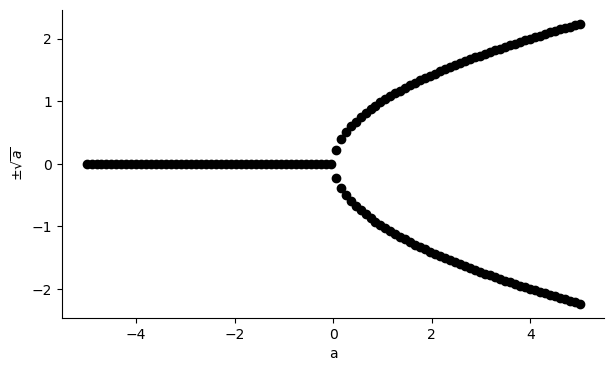

In [6]:
plt.figure(figsize=(7, 4))
ax = plt.subplot(111)
for a in a_vec:
    if a <= 0:
        plt.scatter(a, 0, c="k")
    else:
        fp = np.sqrt(a)
        plt.scatter(a, -fp, c="k")
        plt.scatter(a, fp, c="k")
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.xlabel("a")
plt.ylabel(r"$\pm \sqrt{a}$");

#### Phase diagrams without noise

In [7]:
a_vec = np.array([-5, 0, 5])

In [8]:
Npoints = 10000
fsamp = 1 / 1e-4
Z = simulate(np.zeros((3, 3)), 1, 40, a_vec, fsamp, 0, Npoints, np.zeros((1, Npoints)))

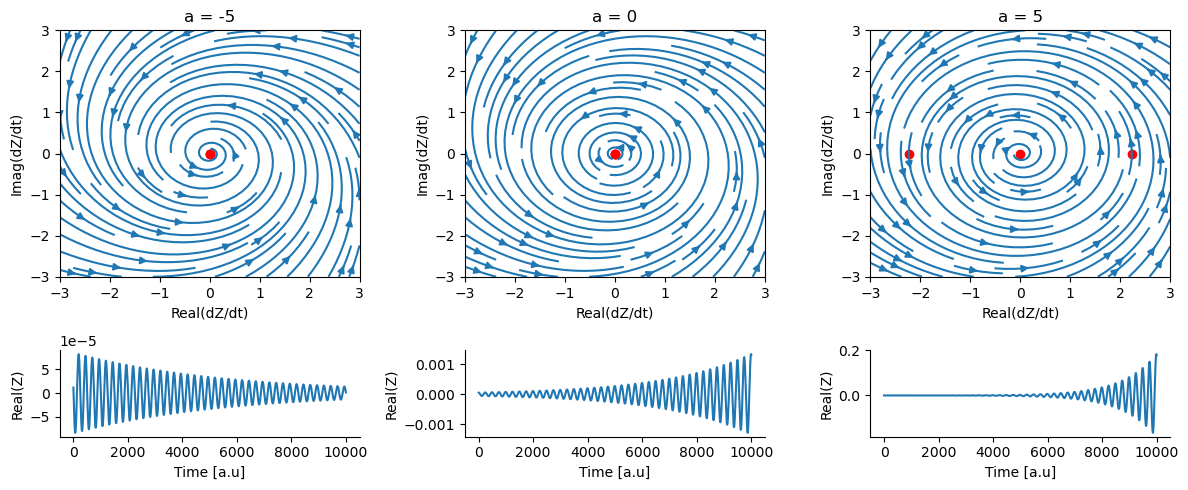

In [9]:
fig, axs = plt.subplot_mosaic([[0, 2, 4], [0, 2, 4], [1, 3, 5]], figsize=(12, 5))

pos = 0
for i, Z_ in enumerate(Z):

    fp = np.sqrt(a_vec[i] + 1j * 0)
    if a_vec[i] < 0:
        fp = 0 + 1j * 0

    fixed_points = np.array([[0.0, 0.0], [fp.real, fp.imag], [-fp.real, -fp.imag]])

    x = np.linspace(-3, 3, 20)
    y = np.linspace(-3, 3, 20)
    X, Y = np.meshgrid(x, y)

    dZdt = _ode(X + 1j * Y, a_vec[i], 40, 0)

    Xdot = dZdt.real
    Ydot = dZdt.imag

    plt.sca(axs[pos])
    axs[pos].streamplot(
        numpy.array(X), numpy.array(Y), numpy.array(Xdot), numpy.array(Ydot)
    )
    axs[pos].scatter(*fixed_points.T, color="r")
    plt.title(f"a = {a_vec[i]}")
    plt.xlabel("Real(dZ/dt)")
    plt.ylabel("Imag(dZ/dt)")

    pos = pos + 1
    plt.sca(axs[pos])
    axs[pos].plot(Z_.real)
    axs[pos].spines["top"].set_visible(False)
    axs[pos].spines["right"].set_visible(False)
    plt.xlabel("Time [a.u]")
    plt.ylabel("Real(Z)")
    pos = pos + 1

plt.tight_layout()

In [13]:
dt = 1e-5
times = np.arange(-.3, 2, dt)
Npoints = len(times)
I = np.zeros((1, Npoints))
I = I.at[:, (times >= 0.5) * (times <= 1)].set(1)

Z = simulate(
    np.zeros((1, 1)),
    0,
    40,
    -1,
    1/dt,
    0,
    Npoints,
    I,
    decim=20,
    stim_mode="both",
)[(times[::20] >= 0)]

In [14]:
import scipy

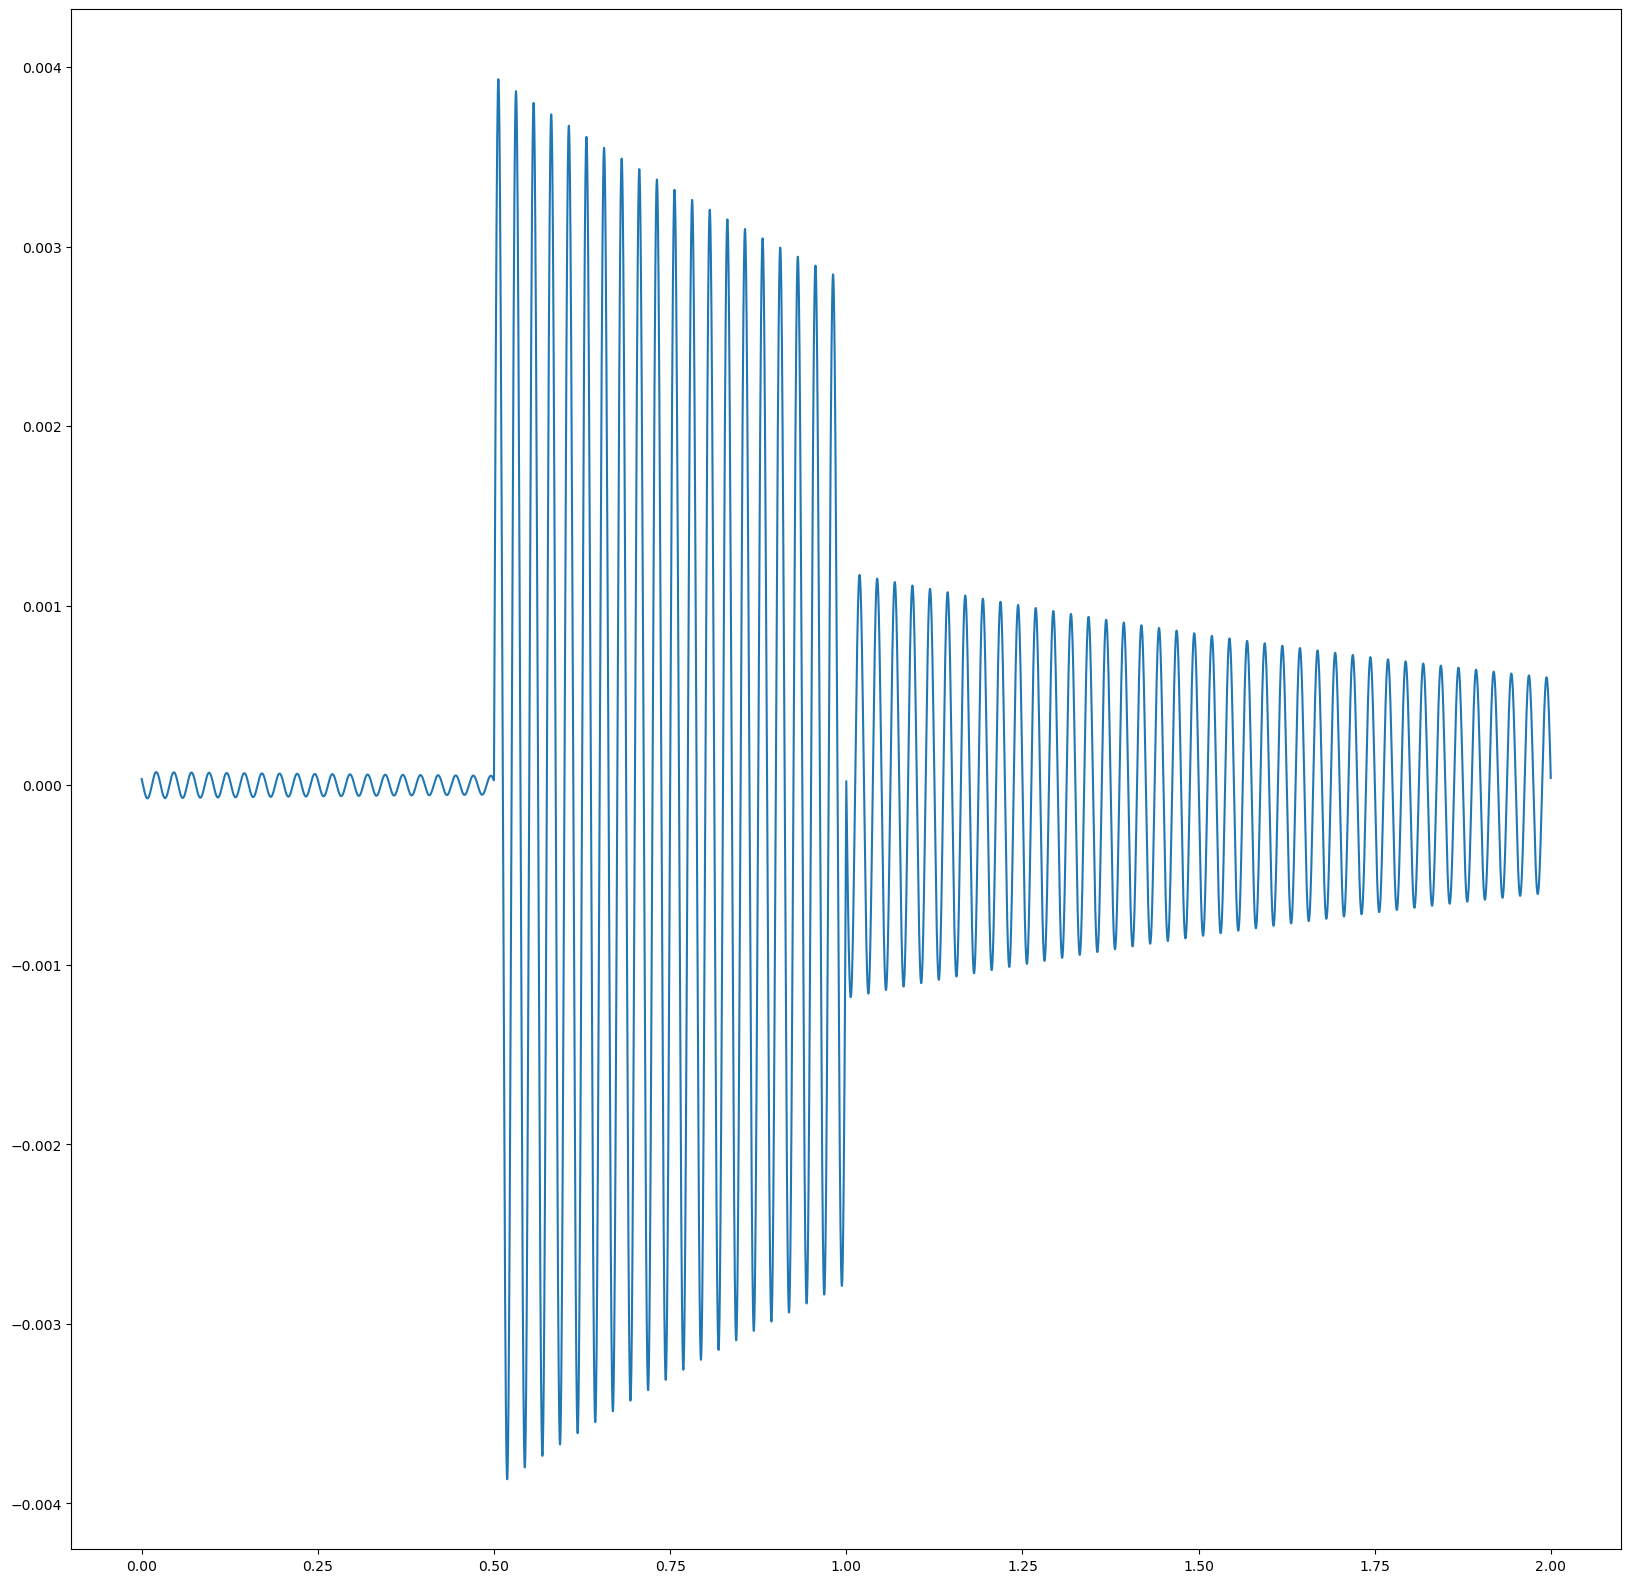

In [15]:
plt.figure(figsize=(20, 20))
plt.plot(times[::20][(times[::20] >= 0)], Z.real)
scipy.io.savemat("z.mat", {"Z": Z.real, "time": times[::20][(times[::20] >= 0)]})

In [119]:
eq(0, -5, 40, 1)

Array(1., dtype=float64, weak_type=True)

In [115]:
np.absolute(Z)[50000:].mean()

Array(0.00397809, dtype=float64)

In [111]:
sin_theta = np.absolute(Z)[50000:].mean() * 2 * np.pi * 40 / 1

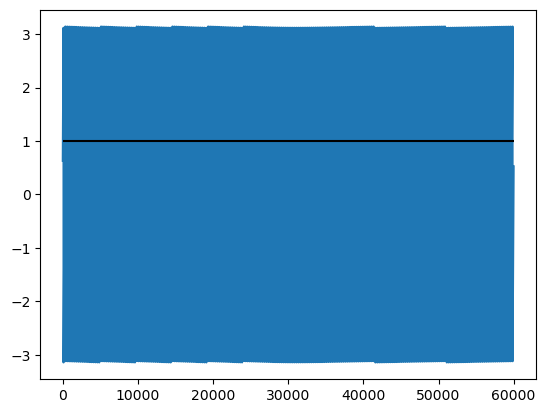

In [143]:
plt.plot(np.angle(Z))
plt.hlines(sin_theta, 0, 60000, "k")

In [69]:
np.cos(1.8) - 5

Array(-0.22720209, dtype=float64, weak_type=True)

#### Input to phase or amplitude

In [33]:
fsamp = 1 / 1e-4
T = np.arange(-5, 30, 1 / fsamp)
Npoints = len(T)
Iext = np.zeros((1, Npoints))
mask = (T >= 0) & (T < 2)
Iext = Iext.at[:, mask].set(2)


Z_amp = simulate2(
    np.zeros((1, 1)), 1, 40, 0, fsamp, 0, Npoints, Iext, np.zeros((1, Npoints))
)


Z_phi = simulate2(
    np.zeros((1, 1)), 1, 40, 0, fsamp, 0, Npoints, np.zeros((1, Npoints)), 200 * Iext
)

Z_both = simulate2(np.zeros((1, 1)), 1, 40, 0, fsamp, 0, Npoints, Iext, Iext * 200)

In [34]:
mask = (T >= -0.5) & (T < 30)

T_ = T[mask]
Z_amp = Z_amp[mask]
Z_phi = Z_phi[mask]
Z_both = Z_both[mask]

In [35]:
onset = np.argmin(np.abs(T_))

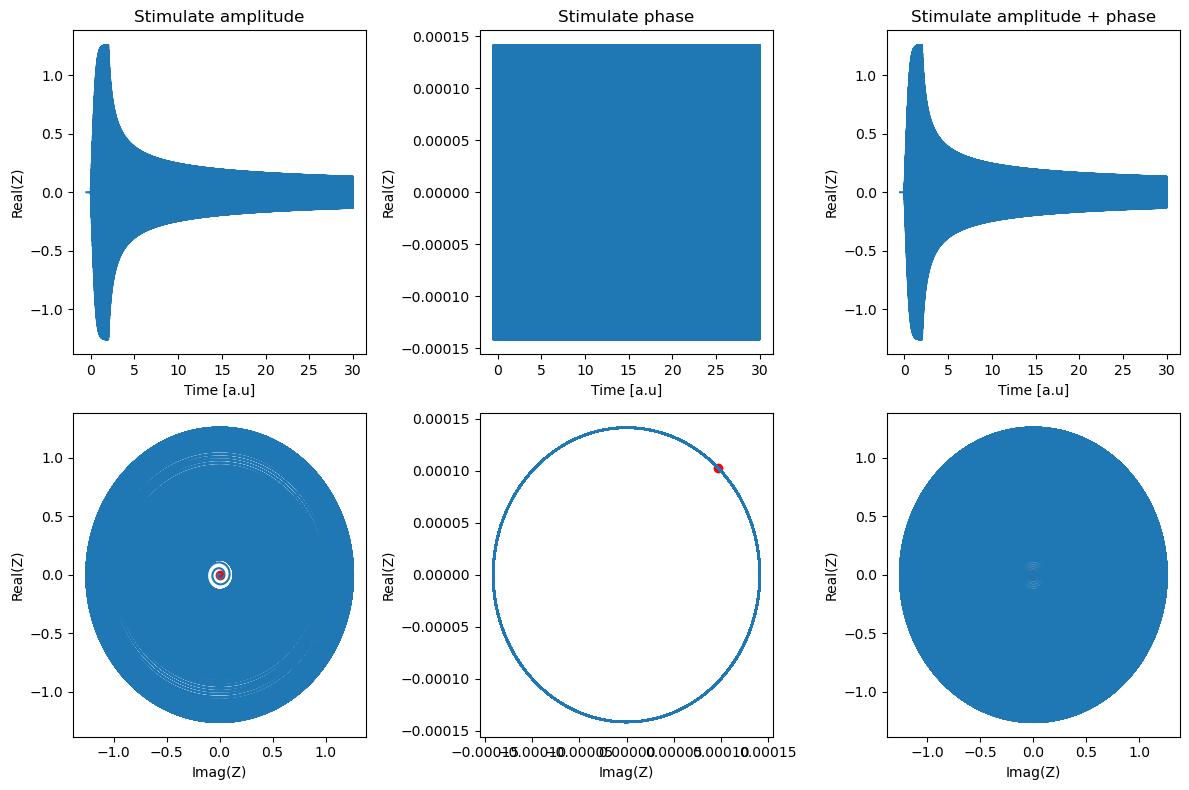

In [36]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.plot(T_, Z_amp.real)
plt.xlabel("Time [a.u]")
plt.ylabel("Real(Z)")
plt.title("Stimulate amplitude")
plt.subplot(232)
plt.plot(T_, Z_phi.real)
plt.xlabel("Time [a.u]")
plt.ylabel("Real(Z)")
plt.title("Stimulate phase")
plt.subplot(233)
plt.plot(T_, Z_both.real)
plt.xlabel("Time [a.u]")
plt.ylabel("Real(Z)")
plt.title("Stimulate amplitude + phase")
plt.subplot(234)
plt.plot(Z_amp.real, Z_amp.imag)
plt.scatter(Z_amp.real[onset], Z_amp.imag[onset], c="r")
plt.xlabel("Imag(Z)")
plt.ylabel("Real(Z)")
plt.subplot(235)
plt.plot(Z_phi.real, Z_phi.imag)
plt.scatter(Z_phi.real[onset], Z_phi.imag[onset], c="r")
plt.xlabel("Imag(Z)")
plt.ylabel("Real(Z)")
plt.subplot(236)
plt.plot(Z_both.real, Z_both.imag)
plt.scatter(Z_both.real[onset], Z_both.imag[onset], c="r")
plt.xlabel("Imag(Z)")
plt.ylabel("Real(Z)")
plt.tight_layout()

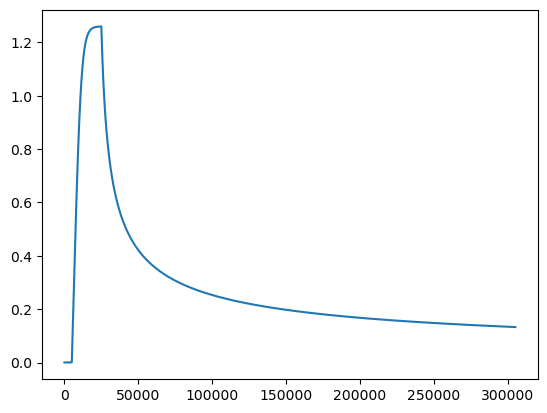

In [37]:
plt.plot(np.abs(Z_both))

In [38]:
np.abs(Z_both)[-1] ** 2

Array(0.01765823, dtype=float64)

In [108]:
np.abs(Z_both)[-1]

Array(0.42080978, dtype=float64)

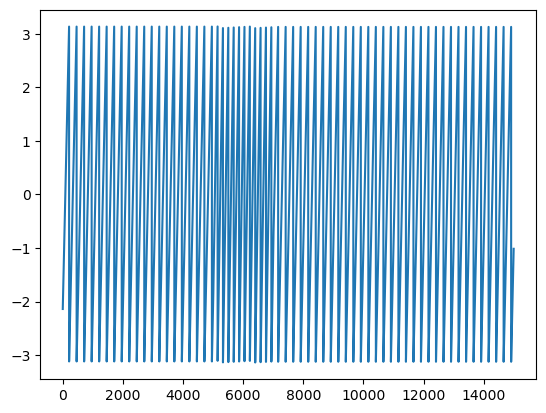

In [101]:
plt.plot(np.angle(Z_both))

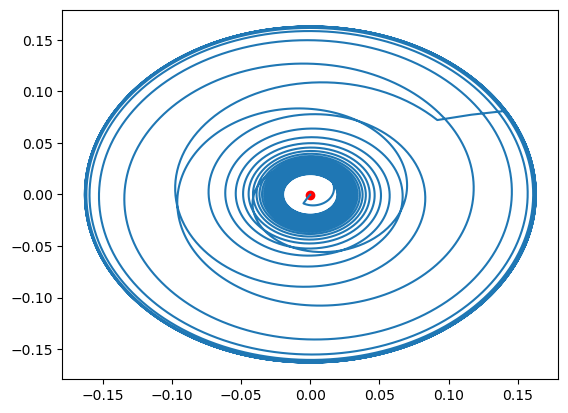

In [98]:
plt.plot(np.gradient(Z_both).real, np.gradient(Z_both).imag)
plt.scatter(Z_both.real[onset], Z_both.imag[onset], c="r")

#### Stimulus encoding

In [15]:
simulate_jax = jax.vmap(simulate, in_axes=(None, None, None, None, 0, 0, None, None))

In [16]:
a_vec = np.linspace(-15, 5, 60)
beta_vec = np.geomspace(1e-4, 1e-3, 60)

In [17]:
T = np.arange(-0.5, 1, 1e-4)
I = np.zeros((100, T.shape[0]))
for i in range(100):
    I = I.at[i, (T >= 0) * (T <= 0.2)].set(1e-4 * i)

In [18]:
seeds = np.arange(100, dtype=int)

In [19]:
out1 = simulate_jax(40, -5, 1e-3, T, I, seeds, 1, "amp")
out2 = simulate_jax(40, 0, 1e-3, T, I, seeds, 1, "amp")
out3 = simulate_jax(40, 5, 1e-3, T, I, seeds, 1, "amp")

Text(0.5, 0, 'time [s]')

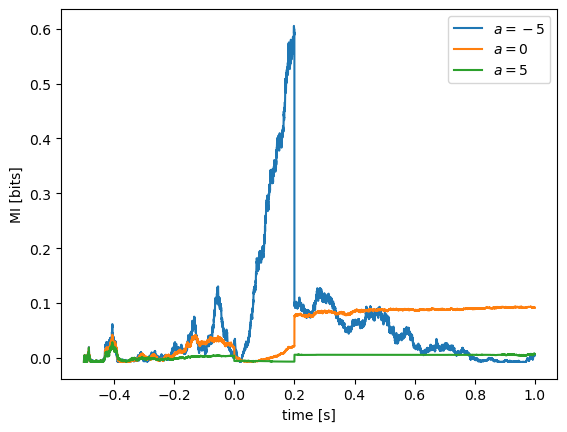

In [20]:
plt.plot(T, gcmi_nd_cc(numpy.asarray(out1 * np.conj(out1)), numpy.asarray(I), traxis=0))
plt.plot(T, gcmi_nd_cc(numpy.asarray(out2 * np.conj(out2)), numpy.asarray(I), traxis=0))
plt.plot(T, gcmi_nd_cc(numpy.asarray(out3 * np.conj(out3)), numpy.asarray(I), traxis=0))

plt.legend([r"$a = -5$", r"$a = 0$", r"$a = 5$"])

plt.ylabel("MI [bits]")
plt.xlabel("time [s]")

In [21]:
grid = np.array(np.meshgrid(a_vec, beta_vec)).T.reshape(-1, 2)
grid.shape

(3600, 2)

In [22]:
simulate_jax_2 = jax.vmap(
    simulate_jax, in_axes=(None, 0, 0, None, None, None, None, None)
)

In [23]:
blocks = np.array_split(np.arange(grid.shape[0]), 600)

In [24]:
grid.shape

(3600, 2)

In [25]:
out = []
for block in tqdm(blocks):
    out += [simulate_jax_2(40, grid[block, 0], grid[block, 1], T, I, seeds, 15, "amp")]

 39%|█████████████████████                                 | 234/600 [01:19<02:04,  2.94it/s]

KeyboardInterrupt



In [22]:
out = numpy.concatenate(out, axis=0)

In [23]:
MIs = []
for _out in tqdm(out):
    try:
        MIs += [
            gcmi_nd_cc(
                numpy.asarray(_out * np.conj(_out)),
                numpy.asarray(I[..., ::15]),
                traxis=0,
            ).max()
        ]
    except:
        MIs += [0]

100%|████████████████████████████████████████████████████| 3600/3600 [01:53<00:00, 31.67it/s]


In [24]:
MIs_xr = xr.DataArray(
    numpy.stack(MIs).reshape(a_vec.shape[0], beta_vec.shape[0]),
    dims=("a", "beta"),
    coords=(a_vec, beta_vec),
    name="MI [bits]",
)

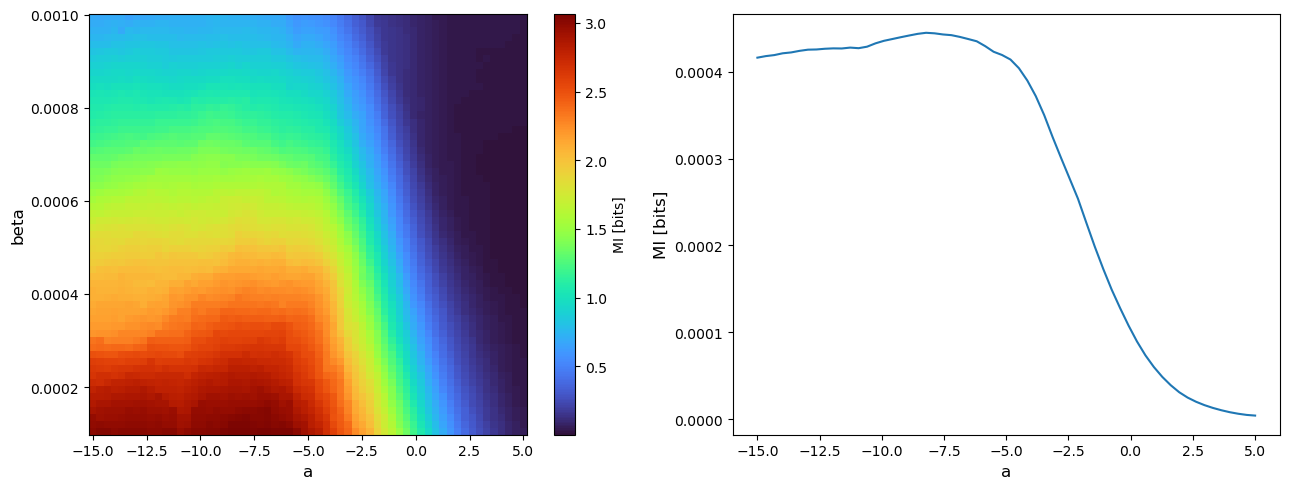

In [25]:
plt.figure(figsize=(13, 5))
plt.subplot(121)
MIs_xr.T.plot.imshow(cmap="turbo")
plt.xlabel("a", fontsize=12)
plt.ylabel("beta", fontsize=12)

plt.subplot(122)
(MIs_xr * numpy.diff(beta_vec)[0]).sum("beta").plot()
plt.xlabel("a", fontsize=12)
plt.ylabel("MI [bits]", fontsize=12)

plt.tight_layout()

#### Two-nodes feed-forward connection (no-delays)

In [25]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/StuartLandauWBM/")

In [26]:
from src.models import simulate

In [27]:
Nareas = 2  # Number of areas
fsamp = 1 / 1e-4
time = np.arange(-0.5, 1, 1 / fsamp)
beta = 1e-3
Npoints = len(time)

f = 40  # np.linspace(20, 60, Nareas)[::-1]  # Node natural frequency in Hz

g = 5
C = np.array([[0, 0], [1, 0]])

In [28]:
T = np.linspace(-0.5, 1, Npoints)
I = np.zeros((100, 2, T.shape[0]))
for i in range(100):
    I = I.at[i, 0, (T >= 0) * (T <= 0.2)].set(1e-3 * i)

In [29]:
simulate_jax = jax.vmap(
    simulate_2nodes, in_axes=(None, None, None, None, None, 0, 0, None, None)
)

In [30]:
seeds = numpy.random.randint(0, 20000, 100, dtype=int)

Z = (
    simulate_jax(g, f, np.array([-5, 0]), beta, T, I, seeds, 15, "amp")
    .squeeze()
    .transpose(0, 2, 1)
)

Text(0.5, 0, 'time [s]')

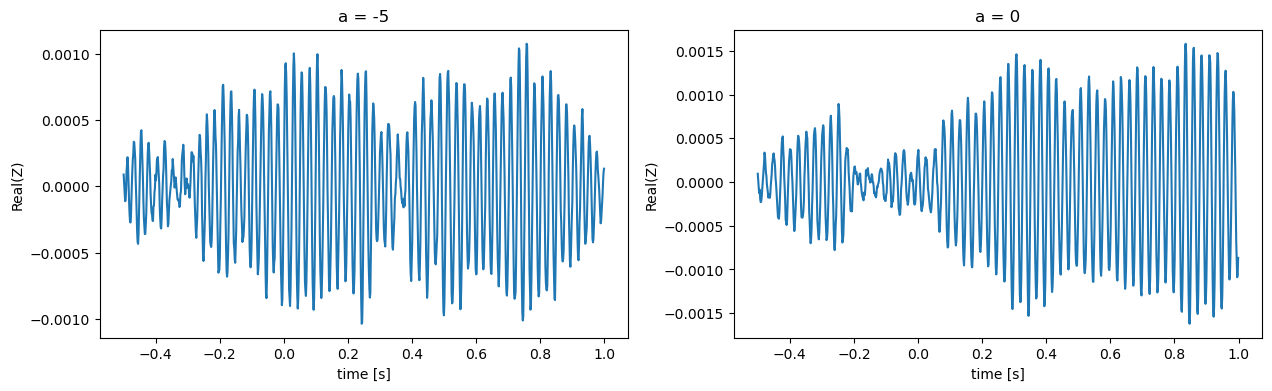

In [31]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(T[::15], Z[0, 0].real)
plt.title("a = -5")
plt.ylabel("Real(Z)")
plt.xlabel("time [s]")
plt.subplot(122)
plt.plot(T[::15], Z[0, 1].real)
plt.title("a = 0")
plt.ylabel("Real(Z)")
plt.xlabel("time [s]")

Text(0.5, 0, 'time [s]')

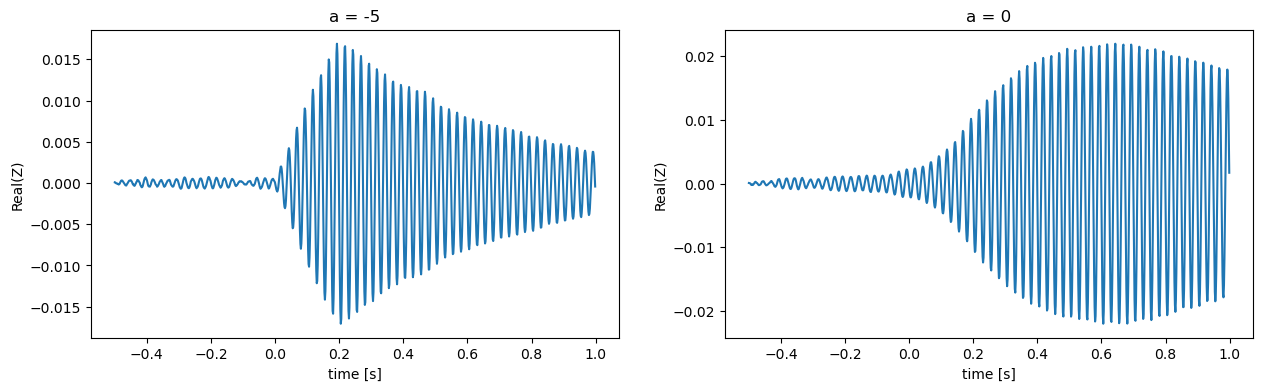

In [32]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(T[::15], Z[-1, 0].real)
plt.title("a = -5")
plt.ylabel("Real(Z)")
plt.xlabel("time [s]")
plt.subplot(122)
plt.plot(T[::15], Z[-1, 1].real)
plt.title("a = 0")
plt.ylabel("Real(Z)")
plt.xlabel("time [s]")

In [33]:
simulate_jax_2 = jax.vmap(
    simulate_jax,
    in_axes=(0, None, None, None, None, None, None, None, None),
)

In [34]:
g_vec = np.linspace(0, 10, 60)

In [35]:
seeds = numpy.random.randint(0, 20000, 100, dtype=int)

Z_homogeneous = (
    numpy.asarray(
        simulate_jax_2(g_vec, f, np.array([-5, -5]), beta, T, I, seeds, 15, "amp")
    )
    .squeeze()
    .transpose(0, 1, 3, 2)
)

seeds = numpy.random.randint(0, 20000, 100, dtype=int)

Z_heterogeneous = (
    numpy.asarray(
        simulate_jax_2(g_vec, f, np.array([-5, 0]), beta, T, I, seeds, 15, "amp")
    )
    .squeeze()
    .transpose(0, 1, 3, 2)
)

In [36]:
mi_homogeneous = []

for i in tqdm(range(60)):
    mi_homogeneous += [
        gccmi_nd_ccc(
            x=numpy.abs(Z_homogeneous[i, :, 0]),
            y=numpy.abs(Z_homogeneous[i, :, 1]),
            z=numpy.array(I[:, 0, ::15]),
            traxis=0,
        )
    ]

mi_homogeneous = np.stack(mi_homogeneous)

100%|████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.37it/s]


In [37]:
mi_heterogeneous = []

for i in tqdm(range(60)):
    mi_heterogeneous += [
        gccmi_nd_ccc(
            x=numpy.abs(Z_heterogeneous[i, :, 0]),
            y=numpy.abs(Z_heterogeneous[i, :, 1]),
            z=numpy.array(I[:, 0, ::15]),
            traxis=0,
        )
    ]

mi_heterogeneous = np.stack(mi_heterogeneous)

100%|████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.82it/s]


(-0.1, 4.0)

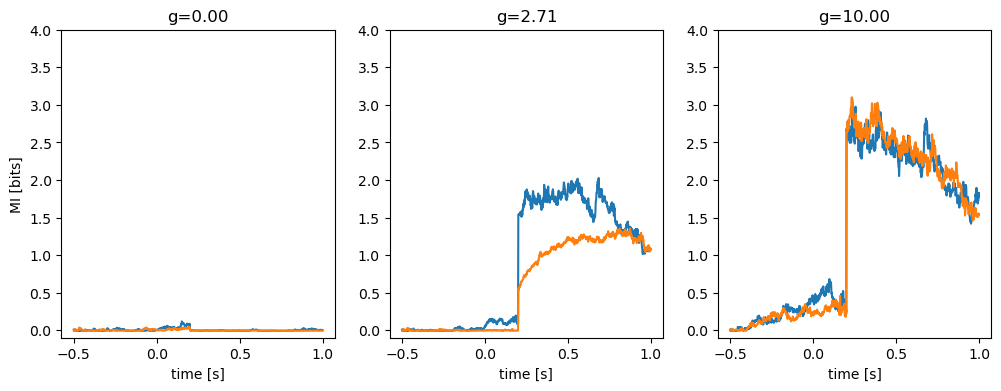

In [38]:
plt.figure(figsize=(12, 4))
plt.subplot((131))
plt.plot(T[::15], mi_homogeneous[0])
plt.plot(T[::15], mi_heterogeneous[0])
plt.ylabel("MI [bits]")
plt.xlabel("time [s]")
plt.title(f"g={g_vec[0]:.2f}")
plt.ylim(-0.1, 4)
plt.subplot((132))
plt.plot(T[::15], mi_homogeneous[16])
plt.plot(T[::15], mi_heterogeneous[16])
plt.xlabel("time [s]")
plt.title(f"g={g_vec[16]:.2f}")
plt.ylim(-0.1, 4)
plt.subplot((133))
plt.plot(T[::15], mi_homogeneous[-1])
plt.plot(T[::15], mi_heterogeneous[-1])
plt.xlabel("time [s]")
plt.title(f"g={g_vec[-1]:.2f}")
plt.ylim(-0.1, 4)

Text(0.5, 0, 'g')

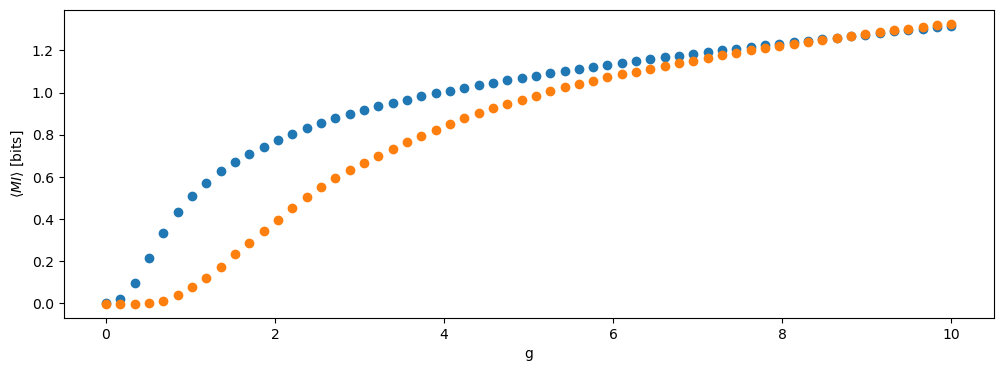

In [39]:
plt.figure(figsize=(12, 4))

plt.plot(g_vec, mi_homogeneous.mean(1), "o")
plt.plot(g_vec, mi_heterogeneous.mean(1), "o")
plt.ylabel(r"$\langle MI \rangle$ [bits]")
plt.xlabel("g")

In [40]:
g_vec = np.linspace(0, 10, 50)
a_vec = np.linspace(-10, 10, 50)

grid = np.array(np.meshgrid(np.array([-5]), a_vec, g_vec)).T.reshape(-1, 3)
grid.shape

(2500, 3)

In [41]:
blocks = np.array_split(np.arange(grid.shape[0]), 100)
blocks[0].shape

(25,)

In [42]:
simulate_jax_3 = jax.vmap(
    simulate_jax,
    in_axes=(0, None, 0, None, None, None, None, None, None),
)

In [43]:
out = []
for block in tqdm(blocks):
    out += [
        numpy.array(
            simulate_jax_3(
                grid[block, 2], f, grid[block, :2], 1e-3, T, I, seeds, 15, "amp"
            )
        )
    ]

result = numpy.concatenate(out).squeeze()
result = result.transpose(0, 1, 3, 2)

mi_low_noise = []

for i in tqdm(range(grid.shape[0])):
    try:
        mi_low_noise += [
            gccmi_nd_ccc(
                x=numpy.abs(result[i, :, 0]),
                y=numpy.abs(result[i, :, 1]),
                z=numpy.array(I[:, 0, ::15]),
                traxis=0,
            )
        ]
    except:
        mi_low_noise += [numpy.zeros_like(T[::15])]

mi_low_noise = np.stack(mi_low_noise)

100%|████████████████████████████████████████████████████| 2500/2500 [02:09<00:00, 19.33it/s]


In [44]:
out = []
for block in tqdm(blocks):
    out += [
        numpy.array(
            simulate_jax_3(
                grid[block, 2], f, grid[block, :2], 1e-2, T, I, seeds, 15, "amp"
            )
        )
    ]

result = numpy.concatenate(out).squeeze()
result = result.transpose(0, 1, 3, 2)

mi_high_noise = []

for i in tqdm(range(grid.shape[0])):
    try:
        mi_high_noise += [
            gccmi_nd_ccc(
                x=numpy.abs(result[i, :, 0]),
                y=numpy.abs(result[i, :, 1]),
                z=numpy.array(I[:, 0, ::15]),
                traxis=0,
            )
        ]
    except:
        mi_high_noise += [numpy.zeros_like(T[::15])]

mi_high_noise = np.stack(mi_high_noise)

100%|████████████████████████████████████████████████████| 2500/2500 [02:09<00:00, 19.25it/s]


In [45]:
mi_low_noise_ = xr.DataArray(
    mi_low_noise.reshape(a_vec.shape[0], g_vec.shape[0], -1).mean(-1),
    dims=(r"$\Delta a$", "g"),
    coords=(-a_vec / 5, g_vec),
    name="MI [bits]",
)

mi_high_noise_ = xr.DataArray(
    mi_high_noise.reshape(a_vec.shape[0], g_vec.shape[0], -1).mean(-1),
    dims=(r"$\Delta a$", "g"),
    coords=(-a_vec / 5, g_vec),
    name="MI [bits]",
)

Text(0.5, 1.0, '$\\beta$ = 1e-2')

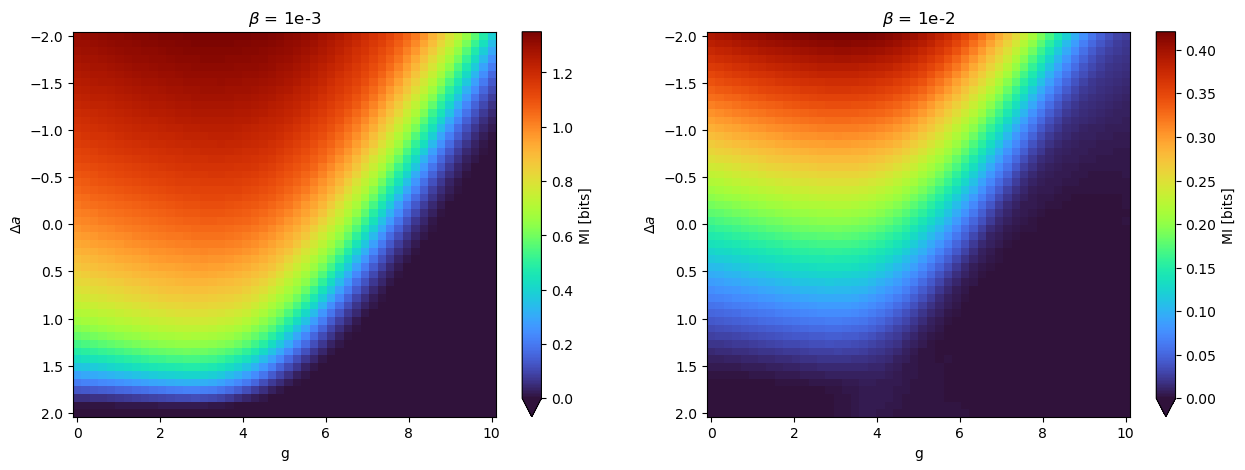

In [46]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
mi_low_noise_.plot.imshow(origin="lower", vmin=0, cmap="turbo")
plt.title(r"$\beta$ = 1e-3")
plt.subplot(122)
mi_high_noise_.plot.imshow(origin="lower", vmin=0, cmap="turbo")
plt.title(r"$\beta$ = 1e-2")

##### Applying PID

In [47]:
fsamp = 1 / 1e-4
T = np.arange(-3, 6, 1 / fsamp)
beta = 1e-3
Npoints = len(T)

f = 40

I = np.zeros((100, 2, T.shape[0]))

for i in range(100):
    I = I.at[i, 0, (T >= 0) * (T <= 1)].set(1e-3 * i)


seeds = numpy.random.randint(0, 50000, len(I))

Z = numpy.array(
    simulate_jax(4, f, np.array([-5, 0]), beta, T, I, seeds, 15, "amp")
    .squeeze()
    .transpose(0, 2, 1)
)

In [48]:
A1, A2 = np.abs(Z[:, 0]), np.abs(Z[:, 1])

dphi = Z[:, 0] * np.conj(Z[:, 1]) / (A1 * A2)

A1 = numpy.asarray(A1)
A2 = numpy.asarray(A2)
dphi = numpy.asarray(dphi)

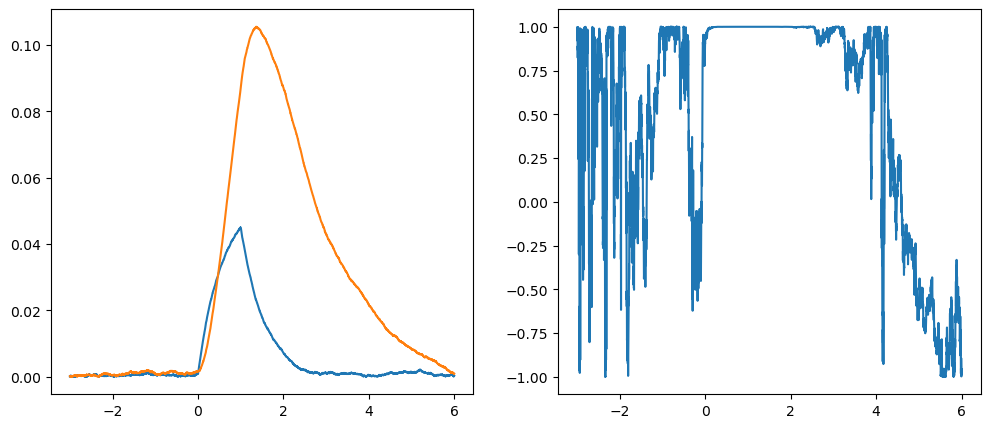

In [49]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(T[::15], A1[-1])
plt.plot(T[::15], A2[-1])
plt.subplot(122)
plt.plot(T[::15], np.real(dphi[-1]))

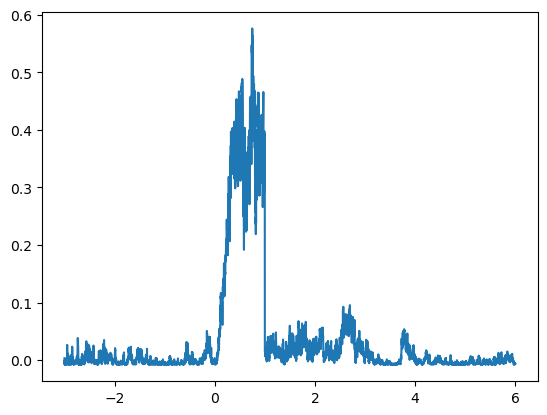

In [50]:
plt.plot(
    T[::15], gcmi_nd_cc(numpy.real(dphi), numpy.array(I.max(1)[..., ::15]), traxis=0)
)

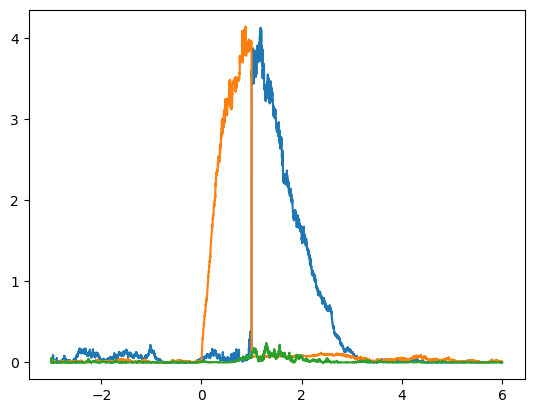

In [51]:
plt.plot(T[::15], gccmi_nd_ccc(A1, A2, numpy.array(I.max(1)[..., ::15]), traxis=0))
plt.plot(T[::15], gcmi_nd_cc(A1 * A2, numpy.array(I.max(1)[..., ::15]), traxis=0))
plt.plot(
    T[::15],
    gccmi_nd_ccc(
        numpy.real(dphi), numpy.imag(dphi), numpy.array(I.max(1)[..., ::15]), traxis=0
    ),
)

In [52]:
stim = numpy.array(I.max(1)[..., ::15])

In [53]:
def _syn(R1, R2, stim):

    MI_13 = gcmi_nd_cc(R1, stim, traxis=0)
    MI_23 = gcmi_nd_cc(R2, stim, traxis=0)
    MI_123 = gccmi_nd_ccc(R1, R2, stim, traxis=0)
    Red = numpy.minimum(MI_13, MI_23)
    return MI_123 - MI_13 - MI_23 + Red

In [55]:
I_S_R1 = gcmi_nd_cc(A1, stim, traxis=0)
I_S_R2 = gcmi_nd_cc(A2, stim, traxis=0)
I_S_R3 = gcmi_nd_cc(dphi, stim, traxis=0)
I_S_R1_R2 = gccmi_nd_ccc(A1, A2, stim, traxis=0)

In [59]:
U_R1 = I_S_R1 - np.minimum(I_S_R1, gccmi_nd_ccc(A2, dphi, stim, traxis=0))

U_R2 = I_S_R3 - np.minimum(I_S_R2, gccmi_nd_ccc(A1, dphi, stim, traxis=0))

U_R3 = I_S_R3 - np.minimum(I_S_R3, gccmi_nd_ccc(A1, A2, stim, traxis=0))

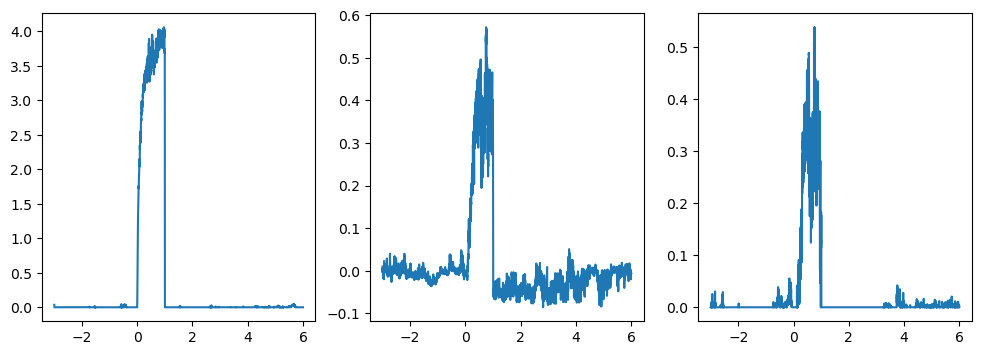

In [60]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(T[::15], U_R1)
plt.subplot(132)
plt.plot(T[::15], U_R2)
plt.subplot(133)
plt.plot(T[::15], U_R3)

In [61]:
T = np.arange(-0.5, 2, 1 / fsamp)

I = np.zeros((100, 2, T.shape[0]))

for i in range(100):
    I = I.at[i, 0, (T >= 0) * (T <= 1)].set(1e-3 * i)

out = []
for block in tqdm(blocks):
    out += [
        numpy.array(
            simulate_jax_3(
                grid[block, 2], f, grid[block, :2], 1e-3, T, I, seeds, 15, "amp"
            )
        )
    ]

Z = numpy.concatenate(out).squeeze()
Z = Z.transpose(0, 1, 3, 2)

100%|██████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.39it/s]


In [62]:
stim = numpy.array(I.max(1)[..., ::15])

In [68]:
U_R1 = []
U_R2 = []
U_R3 = []

for i in tqdm(range(grid.shape[0])):
    A1, A2 = np.abs(Z[i, :, 0]), np.abs(Z[i, :, 1])
    dphi = Z[i, :, 0] * np.conj(Z[i, :, 1]) / (A1 * A2)
    A1 = numpy.asarray(A1)
    A2 = numpy.asarray(A2)
    dphi = numpy.asarray(dphi).real

    try:
        I_S_R1 = gcmi_nd_cc(A1, stim, traxis=0)
        I_S_R2 = gcmi_nd_cc(A2, stim, traxis=0)
        I_S_R3 = gcmi_nd_cc(dphi, stim, traxis=0)
        I_S_R1_R2 = gccmi_nd_ccc(A1, A2, stim, traxis=0)

        U_R1 += [(I_S_R1 - np.minimum(I_S_R1, gccmi_nd_ccc(A2, dphi, stim, traxis=0)))]

        U_R2 += [(I_S_R2 - np.minimum(I_S_R2, gccmi_nd_ccc(A1, dphi, stim, traxis=0)))]

        U_R3 += [(I_S_R3 - np.minimum(I_S_R3, gccmi_nd_ccc(A1, A2, stim, traxis=0)))]

    except:;
        U_R1 += [numpy.zeros_like(T[::15])]
        U_R2 += [numpy.zeros_like(T[::15])]
        U_R3 += [numpy.zeros_like(T[::15])]

100%|████████████████████████████████████████████████████| 2500/2500 [19:09<00:00,  2.17it/s]


In [69]:
np.stack(U_R3)

Array([[0.01559518, 0.        , 0.00601354, ..., 0.        , 0.        ,
        0.        ],
       [0.01559518, 0.        , 0.00618437, ..., 0.        , 0.        ,
        0.        ],
       [0.01559518, 0.        , 0.00685393, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01652447, 0.        , 0.00337964, ..., 0.        , 0.        ,
        0.        ],
       [0.01652447, 0.        , 0.00361895, ..., 0.        , 0.        ,
        0.        ],
       [0.01652447, 0.        , 0.00352317, ..., 0.        , 0.        ,
        0.        ]], dtype=float64)

In [72]:
U_R1_map = xr.DataArray(
    np.stack(U_R1).reshape(a_vec.shape[0], g_vec.shape[0], -1).max(-1),
    dims=(r"$\Delta a$", "g"),
    coords=(-a_vec / 5, g_vec),
    name="Unique(A1) [bits]",
)

U_R2_map = xr.DataArray(
    np.stack(U_R2).reshape(a_vec.shape[0], g_vec.shape[0], -1).max(-1),
    dims=(r"$\Delta a$", "g"),
    coords=(-a_vec / 5, g_vec),
    name="Unique(A2) [bits]",
)

U_R3_map = xr.DataArray(
    np.stack(U_R3).reshape(a_vec.shape[0], g_vec.shape[0], -1).max(-1),
    dims=(r"$\Delta a$", "g"),
    coords=(-a_vec / 5, g_vec),
    name=r"Unique($\Delta\phi$) [bits]",
)

Text(0.5, 1.0, '$\\langle Unique(\\Delta\\phi)\\rangle$ [bits]')

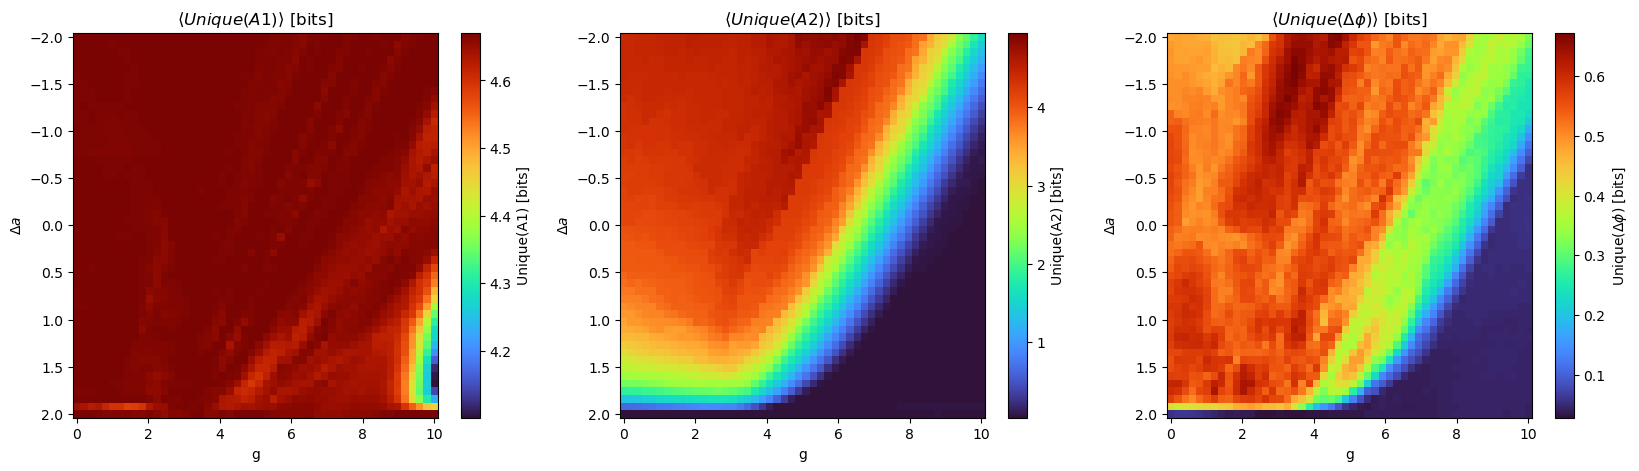

In [73]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
U_R1_map.plot.imshow(origin="lower", cmap="turbo")
plt.title(r"$\langle Unique(A1)\rangle$ [bits]")
plt.subplot(132)
U_R2_map.plot.imshow(origin="lower", cmap="turbo")
plt.title(r"$\langle Unique(A2)\rangle$ [bits]")
plt.subplot(133)
U_R3_map.plot.imshow(origin="lower", cmap="turbo")
plt.title(r"$\langle Unique(\Delta\phi)\rangle$ [bits]")

In [37]:
theta = 0
thetas = []
thetas += [theta]

w = 2 * np.pi * 40

dt = 1e-4

for t in tqdm(range(Npoints)):
    theta = theta + dt * (w - I[0][t] * np.sin(theta) / np.absolute(Z)[t])
    thetas += [theta]
thetas = np.array(thetas)

100%|████████████████████████████████████████████████| 20000/20000 [00:05<00:00, 3955.71it/s]


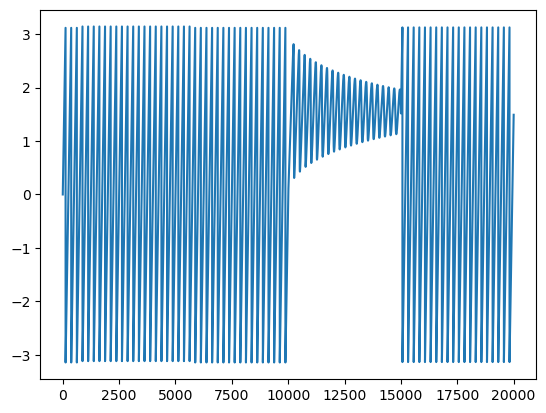

In [39]:
plt.plot(np.angle(np.exp(1j * thetas)))

1.1065120214167474


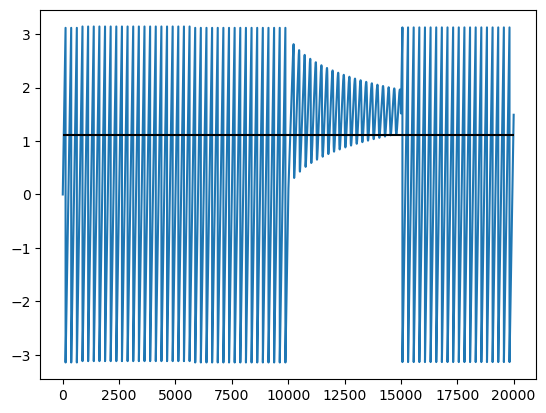

In [65]:
sin_theta = np.absolute(Z)[11000:14000].mean() * 2 * np.pi * 40 / 1
print(sin_theta)

plt.plot(np.angle(np.exp(1j * thetas)))
plt.hlines(sin_theta, 0, 20000, "k")

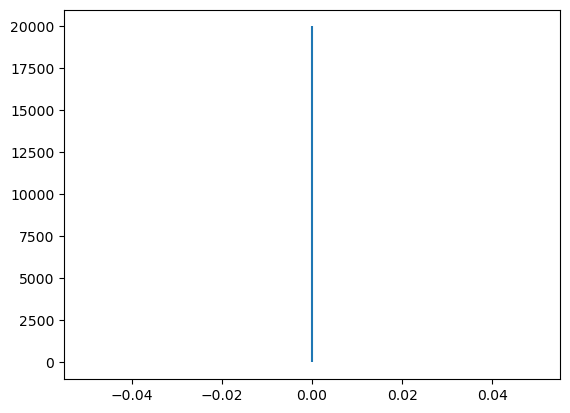

In [62]:
plt.vlines(
    0,
    20000,
    sin_theta,
)

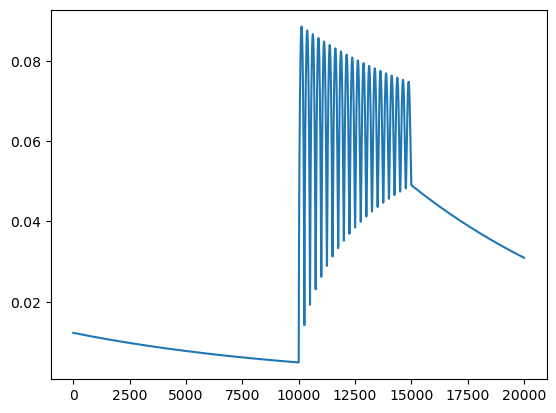

In [57]:
plt.plot(np.sqrt(np.absolute(Z)))